In [1]:
import time
print time.ctime()

Mon Jun  6 02:02:54 2016


<sub>Bei diesem IPython-Notebook handelt es sich um eine Beispiel-Rechnung als Ergänzung zur Dissertationsschrift von C. Knoll. Allgemeine Hinweise zu den Beispielen sind in der [readme.md-Datei des entsprechenden Repositoriums](https://github.com/cknoll/beispiele/blob/master/readme.md) zu finden.</sub>

---

**Betrachtetes System**: Acrobot (=unteraktuierter Zweigelenkmanipulator, Stellglied im Ellenbogengelenk).<br>

<img src="files/images/acrobot_def.png">

**Betrachtete Aspekte**:

* Herleitung der Modellgleichungen in partiell linearisierter Form

* Bestimmung von Trajektorien durch Lösung einer Randwertaufgabe
  * Vergleich: Mit und ohne Berücksichtigung der Integratorketten


[//]: # (custom_config_start)
$$
\newcommand{\col}{\mathrm{col}}
\newcommand{\opspan}{\operatorname{span}}
\newcommand{\bs}{\boldsymbol}
\newcommand{\mb}{\mathbf}
\newcommand{\nx}{n_{\boldsymbol x}}
\newcommand{\Ddt}{\left(\tfrac{d}{dt}\right)}
$$
[//]: # (custom_config_end)


In [2]:
%load_ext displaytools
import sympy as sp
from sympy import sin, cos, pi, simplify
from sympy.interactive import printing
import pickle

import matplotlib.pyplot as pl
%matplotlib inline

import symbtools as st
import symbtools.modeltools as mt
import pycartan as pc

printing.init_printing(1)

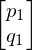

---


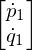

---


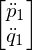

---


In [3]:
t = sp.Symbol('t')
np = 1
nq = 1
n = np + nq
pp = st.symb_vector("p1:{0}".format(np+1))
qq = st.symb_vector("q1:{0}".format(nq+1))


aa = st.symb_vector("a1:{0}".format(nq+1))

ttheta = st.row_stack(pp, qq) ##
tthetad = st.time_deriv(ttheta, ttheta) ##
tthetadd = st.time_deriv(ttheta, ttheta, order=2) ##
st.make_global(ttheta, tthetad)

In [4]:
params = sp.symbols('s1, s2, m1, m2, J1, J2, l1, g, kappa1, kappa2, kappa3, kappa4, kappa5, k')
st.make_global(params)

tau1, tau2 = QQ = st.symb_vector("tau1, tau2")

### Festlegung der Geometrie des mechanischen Systemes

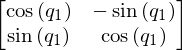

In [5]:
mt.Rz(q1) # Rotationsmatrix

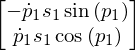

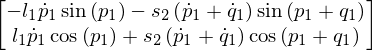

---


In [6]:
#Einheitsvektoren

ex = sp.Matrix([1, 0])
ey = sp.Matrix([0, 1])

# Koordinaten der Schwerpunkte und Gelenke
S1 = mt.Rz(p1)*ex*s1
G1 = mt.Rz(p1)*ex*l1 # "Elllenbogengelenk"
S2 = G1 + mt.Rz(q1 + p1)*ex*s2


# Zeitableitungen der Schwerpunktskoordinaten
Sd1, Sd2 = st.col_split(st.time_deriv(st.col_stack(S1, S2), ttheta)) ##

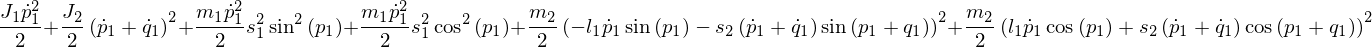

---


---


In [7]:
# Kinetische Energie

T_rot = (J1*pdot1**2)/2 + (J2*(qdot1 + pdot1)**2)/2
T_trans = ( m1*Sd1.T*Sd1  +  m2*Sd2.T*Sd2 )/2

T = T_rot + T_trans[0] ##:

# Potentielle Energie
V = m1*g*S1[1] + m2*g*S2[1] ##:

In [8]:
external_forces = [0, tau1]
assert not any(external_forces[:np])
mod = mt.generate_symbolic_model(T, V, ttheta, external_forces)
mod.eqns.simplify()

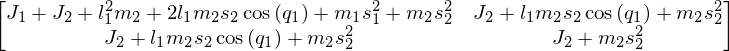

In [9]:
# Massenmatrix
mod.MM

In [10]:
mod.calc_coll_part_lin_state_eq(simplify=True)


### Bestimmung von Trajektorien durch Lösung einer Randwertaufgabe


In [11]:
parameter_values = [(J1, 1.0/6*m1*l1**2), (J2, 1.0/3*m1*l1**2), (l1, .5), (s1, .25), (s2, .25), (m1, 1), (m2, 1), (g, 9.81)]

xx_aa = st.row_stack(mod.xx, mod.aa)

vector_field = (mod.ff + mod.gg*mod.aa).subs(parameter_values)
vf_intern = st.expr_to_func(xx_aa, vector_field, modules='sympy', eltw_vectorize=False, list_wrapper=True)

def vf(x, u):
    xu = list(x) + list(u)
    return vf_intern(*xu)

In [12]:
import pytrajectory

pytrajectory.log.logger.setLevel(20)

# im IPython-Notebook ist stderr-Ausgabe störend. Abschalten:
pytrajectory.logging.root.handlers = [h for h in pytrajectory.logging.root.handlers if not h.stream.name == u'stderr']


# In[24]:

# Randbedingungen:
T0 = 0.0
pi = st.np.pi
xx_start = [3*pi/2, 0, 0, 0]

T_end = 2.0
xx_end = [pi/2, 0, 0, 0]

aa_start = [0.0]*1
aa_end = [0.0]*1


pytrajectory.log.logger.setLevel(30)


results_chains = []
results_no_chains = []


N = 100
#  Das iterierte Lösen der RWA für unterschiendliche Startschätzungen dauert ziemlich lange
# -> Daten zur Anzeige aus Datei laden
pfname = "data/chain_compare_acrobot%i.pcl" % N

if 0:
    for i in range(1):
        print i, "------"
        first_guess = {'seed' : i}
        S_chains = pytrajectory.ControlSystem(vf, T0, T_end, xx_start, xx_end, aa_start, aa_end, use_chains=True, first_guess=first_guess, ierr=None, maxIt=5)
        S_chains.solve()
        nA = S_chains.eqs.trajectories.n_parts_x
        res = (S_chains.reached_accuracy, nA, S_chains.T_sol)
        results_chains.append(res)
        print res
        del S_chains


        S_no_chains = pytrajectory.ControlSystem(vf, T0, T_end, xx_start, xx_end, aa_start, aa_end, use_chains=False, first_guess=first_guess, ierr=None, maxIt=5)
        S_no_chains.solve()
        nA = S_no_chains.eqs.trajectories.n_parts_x
        res = (S_no_chains.reached_accuracy, nA, S_no_chains.T_sol)
        results_no_chains.append(res)
        print res
        del S_no_chains

        print "\n"

    C = st.Container()
    C.results_chains = results_chains
    C.results_no_chains = results_no_chains


    with open(pfname, 'w') as pfile:
        pickle.dump(C, pfile)
else:
    with open(pfname) as pfile:
        C = pickle.load(pfile)
    

In [13]:
#C.results_chains 
#C.results_no_chains 

### Grafische Darstellung der Ergebnisse

[0 1 2 3 4]


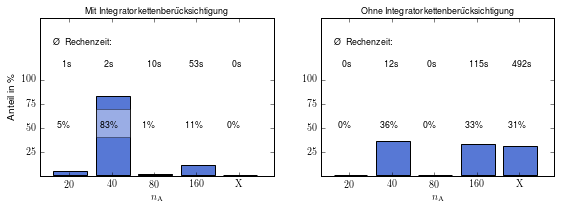

In [14]:
mm = 1./25.4 #mm to inch
scale = 1.5
fs = [78*mm*scale*2, 60*mm*scale*.8]

color_list = ['#5778d5', '#2aa42a', '#d45656', '#000000']

pl.rc('text', usetex=True)

np = st.np




L = len(C.results_chains)
assert L == len(C.results_no_chains)

def unpack(tuplist):
    
    res_dict = {20: [], 40: [], 80:[], 160:[], 1000:[]}
    
    for acc, nA, T in tuplist:
        if not acc:
            res_dict[1000].append(T)
        else:
            res_dict[nA].append(T)
    
    times_list = []
    avg_list = []
    for key, times in sorted(res_dict.items()):
        times_list.append(len(times))
        if len(times) ==0:
            avg_list.append(0)
        else:
            avg_list.append(np.average(times))
            
        
    
    return times_list, avg_list

times_c, avg_c = unpack(C.results_chains)
times_nc, avg_nc = unpack(C.results_no_chains)

T_fin = 6
y_label_X = -.16

if 1:
    
    egal, (ax1, ax2) = pl.subplots(1, 2, figsize=fs)
    
    ax = ax1
    
    #IPS()
    xx = np.arange(len(times_c)) 
    width = 0.8
    ax.bar(xx, times_c, width, color=color_list[0])
    
    yticks = np.r_[25, 50, 75, 100]
    ax.set_yticks(yticks)
    ax.set_xticklabels(yticks)
    
    ax.set_xticks(np.r_[0, 1, 2, 3, 4] + .375)
    #ax.set_xticklabels([20, 40, 80, 160, r'X'], size=10, weight=100)
    ax.set_xticklabels([ "$%s$" % k for k in  [20, 40, 80, 160, r'\mathrm{X}']], size=10, weight=10)
    
    ax.set_ylabel(r'Anteil in \%')
    ax.set_xlabel(r'$n_\mathrm{A}$')
    
    tcl = text_color_list = ['#000000', '#d45656', '#000000', '#000000', '#000000']
    
    # hintergrund für kontrast  
    print xx
    ax.bar(xx[1:2], 30, width, bottom=40, color='white', alpha=.4)
    
    for i in range(len(times_c)):
        ax.text(i+.1, 50, "%i" % times_c[i] + r"\%", size=9)
    
    hT = 115
    hTt = 138
    xTt = 0
    
    ax.set_title(r"Mit Integratorkettenber\"{u}cksichtigung", size=9)
    #ax.text(-.2, 140, r"Mit Integratorkettenber\"{u}cksichtigung", size=9)
    ax.text(xTt, hTt, r"\O ~ Rechenzeit:", size=9)
    for i in range(len(times_c)):
        if np.isnan(avg_c[i]):
            continue
        ax.text(i+.2, hT, "%3.0fs" % avg_c[i], size=9)
    
    
    ax.axis([-.3, 5.2, -1, 165])
    
if 1:    
    ax = ax2
    
    #IPS()
    ax.bar(xx, times_nc, width, color=color_list[0])
    
    ax.set_yticks(np.r_[25, 50, 75, 100])
    ax.set_xticks(np.r_[0, 1, 2, 3, 4] + .375)
    ax.set_xticklabels([ "$%s$" % k for k in  [20, 40, 80, 160, r'\mathrm{X}']])#, size=10, weight=10)
    
    
    #IPS()
    for i in range(len(times_nc)):
        ax.text(i+.1, 50, "%i" % times_nc[i] + r"\%", size=9)
    
    ax.set_title(r"Ohne Integratorkettenber\"{u}cksichtigung", size=9)
    #ax.text(-.2, 140, r"Ohne Integratorkettenber\"{u}cksichtigung", size=9)
    ax.text(xTt, hTt, r"\O ~ Rechenzeit:", size=9)
    for i in range(len(times_nc)):
        if np.isnan(avg_nc[i]):
            continue
        ax.text(i+.2, hT, "%3.0fs" % avg_nc[i], size=9)
        ax.set_xlabel(r'$n_\mathrm{A}$')
    
    
    ax.axis([-.3, 5.2, -1, 165])